# Pavages

## Introduction

On souhaite paver (sans chevauchement) une grille rectangulaire en la remplissant au maximum à l'aide de tuiles (chacune disponible en quantité infinie).

Voici un exemple de pavage optimal (pourquoi est-il optimal?) d'un carré 5x5 à l'aide de tuiles en L (dans n'importe quel sens):
![Exemple](img/ex.png)
Dans cet exemple, seule la case en haut à gauche n'est pas couverte.

## Modélisation par PLNE
Considérons l'ensemble $\mathcal{P}$ des positions possibles d'une tuile sur la grille (exercice: que vaut $\vert \mathcal{P} \vert$ sur l'exemple ci-dessus?). <br>
Définissons une variable $x_k$ par élément $p_k$ de $\mathcal{P}$, valant 1 si la tuile correspondante est posée, 0 sinon. <br>
Définissons $w_k$ comme le nombre de cases occupées par la tuile $p_k$. <br>
On souhaite alors maximiser le nombre de cases couvertes, c'est-à-dire:
$$\sum_k x_k \times w_k$$ 
La contrainte de non-chevauchement s'exprime en disant que chaque case de coordonnée $(i, j)$ est recouverte par au plus une tuile, c'est-à-dire: 
$$\displaystyle\sum_{p_k \in \mathcal{P},\\(i, j) \in p_k} x_k \leq 1$$

Il s'agit d'un **programme linéaire en nombres entiers** (**PLNE**).

## Résolution avec MIP

Malheureusement, la résolution d'un PLNE est plus difficile que celle d'un programme linéaire où les variables sont réelles. <br>
En effet, dans ce deuxième cas, la méthode de l'ellipsoïde/du simplexe donne un algorithme efficace en théorie/en pratique. 

Heureusement, il existe quand même des méthodes pour résoudre un PLNE comme celle de **Branch & Bound** (et ses variations comme **Branch & Cut**). Le package MIP en Python permet d'utiliser un solveur de PLNE s'appuyant sur ce genre de méthodes. <br>
Par défaut, MIP utilise le solveur COIN-OR.

In [1]:
from mip import *
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,4)

Définissons un PLNE avec MIP. <br>
Pour cela, on commence par définir un modèle `m`. <br>
Les variables (binaires: 0 ou 1) sont ajoutées avec `m.add_var`. <br>
On ajoute une contrainte en écrivant `m += ... <= ...`. <br>
`constraints[i][j]` contient la liste des variables (i.e tuiles) couvrant la case $(i, j)$.

In [2]:
def pl(tiles, n, p): # renvoie un modèle de PL pour paver une grille nxp avec des tuiles de tiles
    m, x, w = Model(), [], []
    constraints = [[[] for j in range(p)] for i in range(n)]
    for t in range(len(tiles)):
        a, b = tiles[t].shape
        for i in range(n - a + 1):
            for j in range(p - b + 1):
                x.append(m.add_var(var_type=BINARY, name=str(t)+","+str(i)+","+str(j)))
                w.append(tiles[t].sum())
                for k, l in np.argwhere(tiles[t]):
                    constraints[i + k][j + l].append(x[-1])
    for i in range(len(constraints)):
        for j in range(len(constraints[i])):
            m += xsum(constraints[i][j]) <= 1
    m.objective = maximize(xsum(x[i]*w[i] for i in range(len(x))))
    return m

Une fois ce modèle obtenu, on peut le résoudre:

In [7]:
def solve(tiles, n, p): # affiche un pavage optimal d'une grille nxp avec des tuiles de tiles
    m = pl(tiles, n, p)
    sol = np.zeros((n, p))
    status = m.optimize(max_seconds=60)
    if status == OptimizationStatus.OPTIMAL:
        ntile = 0
        for v in m.vars:
           if abs(v.x) > 1e-6: 
              t, i, j = map(int, v.name.split(",")) # tuile correspondante à la variable v
              ntile += 1
              for k, l in np.argwhere(tiles[t]):
                  sol[i + k, j + l] = ntile
        print("Solution optimale avec", ntile, "tuiles")
        print((sol == 0).sum(), "cases ne sont pas couvertes")
    plt.axis("off")
    plt.imshow(sol, cmap = "gist_ncar")

Essayons:

Solution optimale avec 8 tuiles
1 cases ne sont pas couvertes


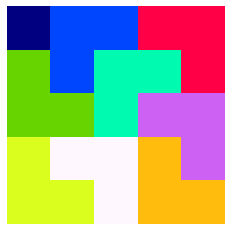

In [9]:
L = np.full((2, 2), True)
L[1, 1] = False # L[i, j] vaut True si (i, j) est occupé par la tuile, False sinon
Ls = [L, L[::-1, :], L[:, ::-1], L[::-1, ::-1]] # les 4 rotations possibles de L
solve(Ls, 5, 5)

On retrouve bien l'exemple initial!

Essayons avec d'autres tuiles, par exemple avec des carrés 2x2:

Solution optimale avec 4 tuiles
9 cases ne sont pas couvertes


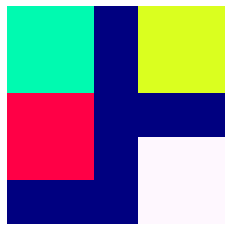

In [10]:
C = np.full((2, 2), True)
solve([C], 5, 5)

Avec des bâtons 4x1: 

Solution optimale avec 6 tuiles
1 cases ne sont pas couvertes


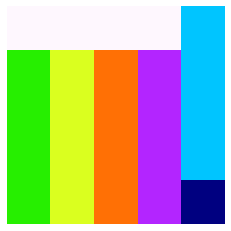

In [11]:
I = np.full((4, 1), True)
Is = [I, I.T] 
solve(Is, 5, 5)

Avec un peu n'importe quoi:

Solution optimale avec 78 tuiles
5 cases ne sont pas couvertes


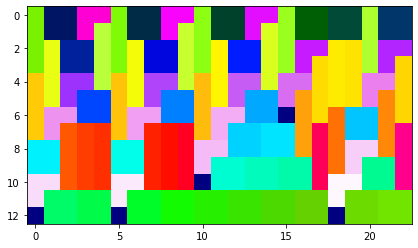

In [15]:
solve([C, I, L], 13, 23)

## Exercices

### Cas 2xn
Dans une grille 2xn, combien peut-on placer de L au maximum? <br>
Quelques exemples:

Solution optimale avec 6 tuiles
2 cases ne sont pas couvertes


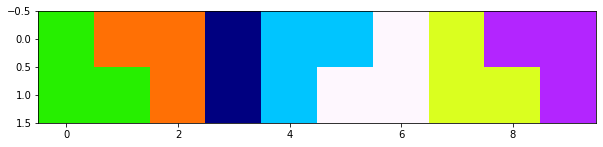

In [9]:
solve(Ls, 2, 10)

Solution optimale avec 7 tuiles
1 cases ne sont pas couvertes


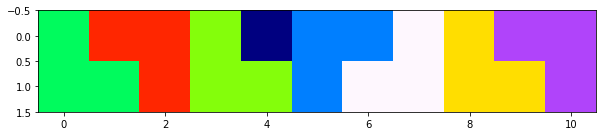

In [10]:
solve(Ls, 2, 11)

Solution optimale avec 8 tuiles
0 cases ne sont pas couvertes


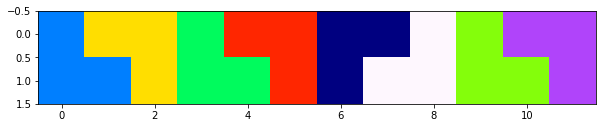

In [11]:
solve(Ls, 2, 12)

Solution optimale avec 8 tuiles
2 cases ne sont pas couvertes


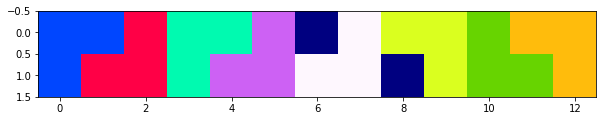

In [12]:
solve(Ls, 2, 13)

### Cas nxn
Dans une grille nxn avec n une puissance de 2, combien peut-on placer de L au maximum? <br>
Donner un algorithme diviser pour régner pour y parvenir.

Solution optimale avec 85 tuiles
1 cases ne sont pas couvertes


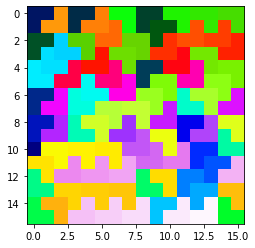

In [13]:
solve(Ls, 16, 16)

### Argument de coloriage

À l'aide d'un argument de coloriage, montrer qu'il est impossible de recouvrir complètement une grille 10x10 avec des I.

Solution optimale avec 24 tuiles
4 cases ne sont pas couvertes


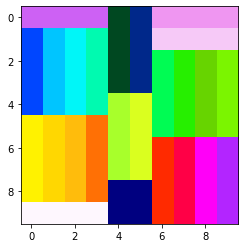

In [14]:
solve(Is, 10, 10)

## Dual

Interpréter le dual du PLNE ci-dessus. A-t-on dualité forte?
